In [1]:
%matplotlib inline

import numpy as np

from matplotlib import rc
import matplotlib.pyplot as plt
import scipy.stats as st

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")


import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

In [2]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        orientation_error = np.tan(alpha + t)*camera_height - ground_distance
    else:
        orientation_error = 0
        
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [3]:
def error_radius_across_pixels(camera, fraction_to_sample=0.5):
    # though this has some randomness associated
    # with a perspective model, pretty much all values are the same across a single X line
    # so to speed this up I'll just do a couple of columns, then repeat it as required
    # to obtain the right image size
    
    # FALSE -- not true! error is lower in the middle!! 
    # => just cut computation time half and reflect
    
    image = np.zeros(shape=(camera.R_y, camera.R_x))
    
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])
    
    columns_to_sample = int(camera.R_x * fraction_to_sample)
    sampled = np.zeros(shape=(camera.R_y, columns_to_sample))
    step = camera.R_x/columns_to_sample # step across image, this makes it usable even in different models with less loss

    for (y,x), _ in np.ndenumerate(sampled):
        x_pix = x * step # take x steps
        ground_point = camera.pixel_to_plane(x_pix, y)
        if ground_point is None:
            ground_distance = 9999999
        else:
            ground_distance = np.linalg.norm(ground_point - camera_ground_pos)
        pixel_area = camera.plane_area_of_pixel(x_pix,y)
        if pixel_area is None:
            pixel_area = 99999999 # some large constant...
        sampled[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]
    
    # repeat the samples to fill the image
    repeats = step
    partial_fill = np.repeat(sampled, repeats).reshape(camera.R_y, -1)
    remaining_cols = image.shape[1] - partial_fill.shape[1]
    if remaining_cols > 0:
        image[:, partial_fill.shape[1]:] = sampled[:, :remaining_cols]
    image[:, :partial_fill.shape[1]] = partial_fill
    
    return image
        

In [4]:
# basically follows the pseudocode from wikipedia for continuous hillclimbing

def hillclimb(score_function, parameter_ranges, parameter_initializations=None, finish_epsilon=0.1, parameter_step_fraction=0.05, acceleration=1.2):
    """ Takes a scoring function, a set of parameter ranges, parameter initializations if desired, the finishing epsilon, and the fraction of the parameter range that one step takes initially    
    """
    
    params = []
    # if no initializations, choose one randomly
    if parameter_initializations is None:
        for param_range in parameter_ranges:
            params.append(np.random.uniform(*param_range))
    else:
        params = parameter_initializations
    params = np.array(params)
    
    params_ranges = np.array([upper - lower for (lower, upper) in parameter_ranges])
    params_step = params_ranges * parameter_step_fraction
    
    movements = np.array([-acceleration, -1.0/acceleration, 0, 1.0/acceleration, acceleration])
    
    
    score = score_function(params)
    while True:
        
        for i, param in enumerate(params):
            
            best_move = -1
            best_score = -9999999
            
            # do 5 steps per param
            # this is relatively inefficient with an expensive cost function
            # since we evaluate '0' parameter each time, which doesn't need to be evaluated...
            for j, move in enumerate(movements):
                params[i] += params_step[i] * move
                
                # check if move is out of bounds!
                if params[i] < parameter_ranges[i][0] or params[i] > parameter_ranges[i][1]:
                    # then skip, can always revert to '0' or no change
                    params[i] -= params_step[i] * move
                    continue
                
                new_score = score_function(params)
                params[i] -= params_step[i] * move
                
                if new_score > best_score:
                    best_score = new_score
                    best_move = j
            
            if movements[best_move] == 0:
                params_step[i] /= acceleration
            else:
                params[i] += params_step[i] * movements[best_move]
                params_step[i] = params_step[i] * movements[best_move] # accelerate step size
           
        updated_score = score_function(params)
        if updated_score - score < finish_epsilon:
            return (score, params)
        score = updated_score
            


In [5]:
# Hill climbing with random restarts

def random_restart_hillclimb(score_function, parameter_ranges, finish_epsilon=0.1, parameter_step_fraction=0.01, acceleration=1.2, num_restarts=100, initialization_generator=None, append_to=None):
    
    if append_to is None:
        local_score_maxima = []
        local_maxima_params = []
    else:
        local_score_maxima = append_to[0]
        local_maxima_params = append_to[1]
    
    for _ in range(num_restarts):
        if initialization_generator is not None:
            init_params = initialization_generator(parameter_ranges)
        else:
            init_params = None
        
        try:
            score, params = hillclimb(score_function, parameter_ranges, parameter_initializations=init_params, finish_epsilon=finish_epsilon, parameter_step_fraction=parameter_step_fraction, acceleration=acceleration)
            print("{0}, params: {1}".format(score, params))

        except Exception as e: # something...
            print("error!", e)
        
        local_score_maxima.append(score)
        local_maxima_params.append(params)
    return (local_score_maxima, local_maxima_params)
        

In [6]:
road_prob_dist = NormalProbabilityDist(two_stddev=0.4)

camera_height = 6.0
resolution = (100, 100)
yaw_range = 60 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # does matter! can see end of road!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitch_range = np.array([31.0, 85.0])

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaw_range = np.array([center_yaw_deg - yaw_range, center_yaw_deg + yaw_range])

fov_h_range = np.array([20.0, 120.0])
fov_v_range = fov_h_range.copy()


In [7]:
def score_function(params):
    pitch, yaw, h_fov, v_fov = params
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(*resolution)
    c.set_fov(h_fov, v_fov)
    
    
    error_bounds = error_radius_across_pixels(c)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    
    target = (1/(1+error_bounds)) * pixel_probabilities
    score = np.sum(target)
    print("--score, params: {0}, {1}".format(score, params))
    return score
    

In [8]:
scores_params = [[],[]]

In [10]:
param_ranges = np.array([
    camera_pitch_range, camera_yaw_range, fov_h_range, fov_v_range
])


random_restart_hillclimb(score_function, param_ranges, finish_epsilon=0.1, parameter_step_fraction=0.1, acceleration=1.5, num_restarts=100000, append_to=scores_params)

--score, params: 0.625289180945, [ 48.82072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.74864768255, [ 40.72072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.673398911021, [ 45.22072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.625289180945, [ 48.82072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.592574041347, [ 52.42072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.565575351609, [ 56.92072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.851148748002, [ 40.72072869  64.70771034  99.06473282  85.29597415]
--score, params: 0.82575444299, [ 40.72072869  74.70771034  99.06473282  85.29597415]
--score, params: 0.74864768255, [ 40.72072869  82.70771034  99.06473282  85.29597415]
--score, params: 0.72347322664, [ 40.72072869  90.70771034  99.06473282  85.29597415]
--score, params: 0.759731230733, [  40.72072869  100.70771034   99.06473282   85.29597415]
--score, params: 0.907280734522, [ 40.72072

--score, params: 1.53042773315, [  63.01840117  130.62023797   72.26199013   54.4065306 ]
--score, params: 2.78483036637, [  63.01840117  130.62023797   42.26199013   39.4065306 ]
--score, params: 2.20617039732, [  63.01840117  130.62023797   42.26199013   47.73986393]
--score, params: 1.86875839221, [  63.01840117  130.62023797   42.26199013   54.4065306 ]
--score, params: 1.60279167655, [  63.01840117  130.62023797   42.26199013   61.07319727]
--score, params: 1.33895335753, [  63.01840117  130.62023797   42.26199013   69.4065306 ]
--score, params: 2.78483036637, [  63.01840117  130.62023797   42.26199013   39.4065306 ]
--score, params: 2.60218076995, [  50.86840117  130.62023797   42.26199013   39.4065306 ]
--score, params: 2.74251700133, [  57.61840117  130.62023797   42.26199013   39.4065306 ]
--score, params: 2.78483036637, [  63.01840117  130.62023797   42.26199013   39.4065306 ]
--score, params: 2.6437125179, [  68.41840117  130.62023797   42.26199013   39.4065306 ]
--score, pa

--score, params: 2.94574521127, [  45.13598629  126.82094248   21.56562103   46.13355984]
--score, params: 2.5114378092, [  45.13598629  126.82094248   21.56562103   23.63355984]
--score, params: 3.42505068132, [  45.13598629  126.82094248   21.56562103   36.13355984]
--score, params: 2.94574521127, [  45.13598629  126.82094248   21.56562103   46.13355984]
--score, params: 2.31284358037, [  45.13598629  126.82094248   21.56562103   56.13355984]
--score, params: 1.76729084282, [  45.13598629  126.82094248   21.56562103   68.63355984]
--score, params: 3.42505068132, [  45.13598629  126.82094248   21.56562103   36.13355984]
--score, params: 1.12823129056, [  37.03598629  126.82094248   21.56562103   36.13355984]
--score, params: 2.44665121421, [  41.53598629  126.82094248   21.56562103   36.13355984]
--score, params: 3.42505068132, [  45.13598629  126.82094248   21.56562103   36.13355984]
--score, params: 3.78826011832, [  48.73598629  126.82094248   21.56562103   36.13355984]
--score, pa

--score, params: 1.51095179024, [ 38.30231299  85.29171146  72.42156074  72.40723135]
--score, params: 1.42547266921, [ 38.30231299  85.29171146  79.08822741  72.40723135]
--score, params: 1.29564056666, [ 38.30231299  85.29171146  87.42156074  72.40723135]
--score, params: 2.12222563729, [ 38.30231299  85.29171146  57.42156074  57.40723135]
--score, params: 1.81255520384, [ 38.30231299  85.29171146  57.42156074  65.74056468]
--score, params: 1.575707848, [ 38.30231299  85.29171146  57.42156074  72.40723135]
--score, params: 1.37578736765, [ 38.30231299  85.29171146  57.42156074  79.07389802]
--score, params: 1.16467875094, [ 38.30231299  85.29171146  57.42156074  87.40723135]
--score, params: 2.12222563729, [ 38.30231299  85.29171146  57.42156074  57.40723135]
--score, params: 1.83292800904, [ 50.45231299  85.29171146  57.42156074  57.40723135]
--score, params: 1.9896027831, [ 43.70231299  85.29171146  57.42156074  57.40723135]
--score, params: 2.12222563729, [ 38.30231299  85.2917114

--score, params: 1.9694427501, [ 32.37815016  91.49137152  28.29511338  71.82024992]
--score, params: 1.993897676, [ 32.37815016  91.49137152  24.59140968  71.82024992]
--score, params: 2.01501318475, [ 32.37815016  91.49137152  21.62844671  71.82024992]
--score, params: 1.51020345045, [ 32.37815016  91.49137152  21.62844671  86.82024992]
--score, params: 1.77074325572, [ 32.37815016  91.49137152  21.62844671  78.48691659]
--score, params: 2.01501318475, [ 32.37815016  91.49137152  21.62844671  71.82024992]
--score, params: 1.98886246861, [ 32.37815016  91.49137152  21.62844671  65.15358326]
--score, params: 0.130182938225, [ 32.37815016  91.49137152  21.62844671  56.82024992]
--score, params: 2.01501318475, [ 32.37815016  91.49137152  21.62844671  71.82024992]
2.01501318475, params: [ 32.37815016  91.49137152  21.62844671  71.82024992]
--score, params: 0.943966143189, [ 68.81172387  98.6835506   26.67673997  92.36621554]
--score, params: 0.935232568681, [ 60.71172387  98.6835506   26.

--score, params: 1.02450020477, [ 42.95815562  46.84275862  69.94708104  77.96149203]
--score, params: 1.15557793391, [ 42.95815562  73.84275862  69.94708104  77.96149203]
--score, params: 1.07040007651, [ 42.95815562  58.84275862  69.94708104  77.96149203]
--score, params: 1.02450020477, [ 42.95815562  46.84275862  69.94708104  77.96149203]
--score, params: 0.926226450515, [ 42.95815562  34.84275862  69.94708104  77.96149203]
--score, params: 0.977499316522, [ 42.95815562  73.84275862  92.44708104  77.96149203]
--score, params: 1.06638980459, [ 42.95815562  73.84275862  79.94708104  77.96149203]
--score, params: 1.15557793391, [ 42.95815562  73.84275862  69.94708104  77.96149203]
--score, params: 1.27533065724, [ 42.95815562  73.84275862  59.94708104  77.96149203]
--score, params: 1.34325569564, [ 42.95815562  73.84275862  47.44708104  77.96149203]
--score, params: 0.856758235917, [  42.95815562   73.84275862   47.44708104  100.46149203]
--score, params: 1.10052444158, [ 42.95815562  

--score, params: 4.86890629126, [ 52.55815562  48.50942529  22.44708104  28.79482536]
--score, params: 4.70489954907, [ 52.55815562  56.50942529  22.44708104  28.79482536]
--score, params: 4.80293750492, [ 52.55815562  52.06498085  22.44708104  28.79482536]
--score, params: 4.86890629126, [ 52.55815562  48.50942529  22.44708104  28.79482536]
--score, params: 4.69668769921, [ 52.55815562  44.95386973  22.44708104  28.79482536]
--score, params: 4.19368759116, [ 52.55815562  40.50942529  22.44708104  28.79482536]
--score, params: 4.30180931317, [ 52.55815562  48.50942529  29.11374771  28.79482536]
--score, params: 4.68696280002, [ 52.55815562  48.50942529  25.410044    28.79482536]
--score, params: 4.86890629126, [ 52.55815562  48.50942529  22.44708104  28.79482536]
--score, params: 3.02899461839, [ 52.55815562  48.50942529  22.44708104  43.79482536]
--score, params: 3.87604956732, [ 52.55815562  48.50942529  22.44708104  35.46149203]
--score, params: 4.86890629126, [ 52.55815562  48.5094

--score, params: 1.3038916892, [  77.68153196  116.94457032   91.15067038   59.52926237]
--score, params: 1.46797503641, [  77.68153196  116.94457032   78.65067038   59.52926237]
--score, params: 1.6011321731, [  77.68153196  116.94457032   68.65067038   59.52926237]
--score, params: 1.77268998741, [  77.68153196  116.94457032   58.65067038   59.52926237]
--score, params: 1.97779469189, [  77.68153196  116.94457032   46.15067038   59.52926237]
--score, params: 1.23569136706, [  77.68153196  116.94457032   46.15067038   82.02926237]
--score, params: 1.59345150742, [  77.68153196  116.94457032   46.15067038   69.52926237]
--score, params: 1.97779469189, [  77.68153196  116.94457032   46.15067038   59.52926237]
--score, params: 2.22440780853, [  77.68153196  116.94457032   46.15067038   49.52926237]
--score, params: 2.06992696112, [  77.68153196  116.94457032   46.15067038   37.02926237]
--score, params: 2.22440780853, [  77.68153196  116.94457032   46.15067038   49.52926237]
--score, par

--score, params: 6.22582102837, [  61.48153196  130.27790365   21.15067038   20.08481792]
--score, params: 6.63995256487, [  61.48153196  122.27790365   27.81733704   20.08481792]
--score, params: 6.82664485983, [  61.48153196  122.27790365   24.11363334   20.08481792]
--score, params: 6.93006816905, [  61.48153196  122.27790365   21.15067038   20.08481792]
--score, params: 5.10029833334, [  61.48153196  122.27790365   21.15067038   26.75148459]
--score, params: 5.99957784382, [  61.48153196  122.27790365   21.15067038   23.04778089]
--score, params: 6.93006816905, [  61.48153196  122.27790365   21.15067038   20.08481792]
--score, params: 6.93006816905, [  61.48153196  122.27790365   21.15067038   20.08481792]
--score, params: 5.12984932351, [  66.88153196  122.27790365   21.15067038   20.08481792]
--score, params: 6.55217788059, [  63.88153196  122.27790365   21.15067038   20.08481792]
--score, params: 6.93006816905, [  61.48153196  122.27790365   21.15067038   20.08481792]
--score, p

--score, params: 1.46932350983, [ 83.69141105  62.20254444  34.75961039  80.19242568]
--score, params: 1.73514403267, [ 83.69141105  62.20254444  34.75961039  71.85909234]
--score, params: 1.98658931867, [ 83.69141105  62.20254444  34.75961039  65.19242568]
--score, params: 2.07818981652, [ 83.69141105  62.20254444  34.75961039  58.52575901]
--score, params: 1.75700770763, [ 83.69141105  62.20254444  34.75961039  50.19242568]
--score, params: 2.07818981652, [ 83.69141105  62.20254444  34.75961039  58.52575901]
1.98658931867, params: [ 83.69141105  62.20254444  34.75961039  58.52575901]
--score, params: 2.68176601575, [  58.23898585  137.86333744   54.11319263   29.74092053]
--score, params: 1.79521777473, [  50.13898585  137.86333744   54.11319263   29.74092053]
--score, params: 2.27499555371, [  54.63898585  137.86333744   54.11319263   29.74092053]
--score, params: 2.68176601575, [  58.23898585  137.86333744   54.11319263   29.74092053]
--score, params: 2.94893663489, [  61.83898585 

--score, params: 2.19878405875, [ 47.94708685  52.00498907  22.46997652  57.42574152]
--score, params: 2.12247001035, [ 47.94708685  52.00498907  29.13664318  57.42574152]
--score, params: 1.90338863307, [ 47.94708685  52.00498907  37.46997652  57.42574152]
--score, params: 3.19097054151, [ 47.94708685  52.00498907  22.46997652  42.42574152]
--score, params: 2.57045322433, [ 47.94708685  52.00498907  22.46997652  50.75907486]
--score, params: 2.19878405875, [ 47.94708685  52.00498907  22.46997652  57.42574152]
--score, params: 1.90080112214, [ 47.94708685  52.00498907  22.46997652  64.09240819]
--score, params: 1.60052121315, [ 47.94708685  52.00498907  22.46997652  72.42574152]
--score, params: 3.19097054151, [ 47.94708685  52.00498907  22.46997652  42.42574152]
--score, params: 3.09513746467, [ 60.09708685  52.00498907  22.46997652  42.42574152]
--score, params: 3.10973107724, [ 53.34708685  52.00498907  22.46997652  42.42574152]
--score, params: 3.19097054151, [ 47.94708685  52.0049

--score, params: 1.24359761377, [ 52.06491881  95.41213668  83.21306802  65.27934807]
--score, params: 1.048608784, [ 52.06491881  95.41213668  91.54640135  65.27934807]
--score, params: 2.12366893764, [ 52.06491881  95.41213668  61.54640135  50.27934807]
--score, params: 1.73641660476, [ 52.06491881  95.41213668  61.54640135  58.6126814 ]
--score, params: 1.49552311984, [ 52.06491881  95.41213668  61.54640135  65.27934807]
--score, params: 1.29709926536, [ 52.06491881  95.41213668  61.54640135  71.94601474]
--score, params: 1.09234619674, [ 52.06491881  95.41213668  61.54640135  80.27934807]
--score, params: 2.12366893764, [ 52.06491881  95.41213668  61.54640135  50.27934807]
--score, params: 2.02771152157, [ 64.21491881  95.41213668  61.54640135  50.27934807]
--score, params: 2.05290853533, [ 57.46491881  95.41213668  61.54640135  50.27934807]
--score, params: 2.12366893764, [ 52.06491881  95.41213668  61.54640135  50.27934807]
--score, params: 2.24532552659, [ 46.66491881  95.412136

--score, params: 1.60135660062, [  84.36334926  133.85308436   37.04773516   78.47551478]
--score, params: 1.7511136104, [  84.36334926  133.85308436   31.49217961   78.47551478]
--score, params: 1.85300425087, [  84.36334926  133.85308436   27.04773516   78.47551478]
--score, params: 1.90641537264, [  84.36334926  133.85308436   22.60329072   78.47551478]
--score, params: 1.57444535372, [  84.36334926  133.85308436   22.60329072   88.47551478]
--score, params: 1.75181519328, [  84.36334926  133.85308436   22.60329072   82.91995922]
--score, params: 1.90641537264, [  84.36334926  133.85308436   22.60329072   78.47551478]
--score, params: 2.01524613168, [  84.36334926  133.85308436   22.60329072   74.03107034]
--score, params: 1.9170311044, [  84.36334926  133.85308436   22.60329072   68.47551478]
--score, params: 2.01524613168, [  84.36334926  133.85308436   22.60329072   74.03107034]
--score, params: 1.933830426, [  80.76334926  133.85308436   22.60329072   74.03107034]
--score, param

--score, params: 5.76665837838, [  60.17156457  115.26582343   25.328924     23.01416547]
--score, params: 5.89160858741, [  60.17156457  120.59915676   25.328924     23.01416547]
--score, params: 6.0062216245, [  60.17156457  125.93249009   25.328924     23.01416547]
--score, params: 5.49425057584, [  60.17156457  132.59915676   25.328924     23.01416547]
--score, params: 5.47151206078, [  60.17156457  125.93249009   35.328924     23.01416547]
--score, params: 5.83092483111, [  60.17156457  125.93249009   29.77336845   23.01416547]
--score, params: 6.0062216245, [  60.17156457  125.93249009   25.328924     23.01416547]
--score, params: 6.11078694021, [  60.17156457  125.93249009   20.88447956   23.01416547]
--score, params: 4.10564391317, [  60.17156457  125.93249009   20.88447956   33.01416547]
--score, params: 5.04170813692, [  60.17156457  125.93249009   20.88447956   27.45860992]
--score, params: 6.11078694021, [  60.17156457  125.93249009   20.88447956   23.01416547]
--score, par

--score, params: 1.23666588442, [ 35.95078968  98.8297352   93.25123885  64.21695724]
--score, params: 0.911034853627, [  35.95078968   86.8297352   115.75123885   64.21695724]
--score, params: 1.19081991237, [  35.95078968   86.8297352   103.25123885   64.21695724]
--score, params: 1.45944092391, [ 35.95078968  86.8297352   93.25123885  64.21695724]
--score, params: 1.73614770698, [ 35.95078968  86.8297352   83.25123885  64.21695724]
--score, params: 1.89119500639, [ 35.95078968  86.8297352   70.75123885  64.21695724]
--score, params: 1.06488378501, [ 35.95078968  86.8297352   70.75123885  54.21695724]
--score, params: 1.91722774648, [ 35.95078968  86.8297352   70.75123885  59.7725128 ]
--score, params: 1.89119500639, [ 35.95078968  86.8297352   70.75123885  64.21695724]
--score, params: 1.72651138033, [ 35.95078968  86.8297352   70.75123885  68.66140169]
--score, params: 1.53731634713, [ 35.95078968  86.8297352   70.75123885  74.21695724]
--score, params: 1.91722774648, [ 35.95078968

--score, params: 2.05106807104, [ 33.78693132  73.62588624  21.95866908  69.27909076]
--score, params: 2.05089547473, [ 33.78693132  81.62588624  21.95866908  69.27909076]
--score, params: 2.05051855488, [ 33.78693132  89.62588624  21.95866908  69.27909076]
--score, params: 2.04960380085, [ 33.78693132  99.62588624  21.95866908  69.27909076]
--score, params: 1.93327462389, [ 33.78693132  73.62588624  36.95866908  69.27909076]
--score, params: 1.99948539182, [ 33.78693132  73.62588624  28.62533574  69.27909076]
--score, params: 2.05106807104, [ 33.78693132  73.62588624  21.95866908  69.27909076]
--score, params: 1.06857370486, [  33.78693132   73.62588624   21.95866908  103.02909076]
--score, params: 1.53315712773, [ 33.78693132  73.62588624  21.95866908  84.27909076]
--score, params: 2.05106807104, [ 33.78693132  73.62588624  21.95866908  69.27909076]
--score, params: 0.711320833762, [ 33.78693132  73.62588624  21.95866908  54.27909076]
--score, params: 4.9816873009e-10, [ 33.78693132 

--score, params: 4.02248702219, [ 51.71547564  84.86939857  22.13547993  31.98909577]
--score, params: 0.0405489829744, [ 43.61547564  84.86939857  22.13547993  31.98909577]
--score, params: 1.59981265865e-23, [ 33.49047564  84.86939857  22.13547993  31.98909577]
--score, params: 4.03959475388, [  51.71547564  102.86939857   22.13547993   31.98909577]
--score, params: 4.02009908649, [ 51.71547564  92.86939857  22.13547993  31.98909577]
--score, params: 4.02248702219, [ 51.71547564  84.86939857  22.13547993  31.98909577]
--score, params: 4.04162441154, [ 51.71547564  76.86939857  22.13547993  31.98909577]
--score, params: 4.11047948544, [ 51.71547564  66.86939857  22.13547993  31.98909577]
--score, params: 2.65590157925, [ 51.71547564  66.86939857  55.88547993  31.98909577]
--score, params: 3.6498315658, [ 51.71547564  66.86939857  37.13547993  31.98909577]
--score, params: 4.11047948544, [ 51.71547564  66.86939857  22.13547993  31.98909577]
--score, params: 2.65837149416, [ 51.71547564

--score, params: 2.49957842092, [ 79.33227024  67.96499496  26.59734639  51.67973485]
--score, params: 2.4549242741, [ 82.93227024  67.96499496  26.59734639  51.67973485]
--score, params: 2.36142903213, [ 79.33227024  85.96499496  26.59734639  51.67973485]
--score, params: 2.41361612865, [ 79.33227024  75.96499496  26.59734639  51.67973485]
--score, params: 2.49957842092, [ 79.33227024  67.96499496  26.59734639  51.67973485]
--score, params: 2.52986278674, [ 79.33227024  59.96499496  26.59734639  51.67973485]
--score, params: 2.02171906028, [ 79.33227024  49.96499496  26.59734639  51.67973485]
--score, params: 1.76217019936, [ 79.33227024  59.96499496  60.34734639  51.67973485]
--score, params: 2.10034886626, [ 79.33227024  59.96499496  41.59734639  51.67973485]
--score, params: 2.52986278674, [ 79.33227024  59.96499496  26.59734639  51.67973485]
--score, params: 1.88723485648, [ 79.33227024  59.96499496  26.59734639  66.67973485]
--score, params: 2.25689934285, [ 79.33227024  59.96499

--score, params: 2.13508492451, [ 81.59826951  60.09017391  20.57659713  63.44220654]
--score, params: 1.99964093802, [ 81.59826951  70.09017391  20.57659713  63.44220654]
--score, params: 1.90657634322, [ 81.59826951  52.09017391  35.57659713  63.44220654]
--score, params: 2.14109040328, [ 81.59826951  52.09017391  27.2432638   63.44220654]
--score, params: 2.27925373919, [ 81.59826951  52.09017391  20.57659713  63.44220654]
--score, params: 1.7001500696, [ 81.59826951  52.09017391  20.57659713  78.44220654]
--score, params: 2.00436751909, [ 81.59826951  52.09017391  20.57659713  70.10887321]
--score, params: 2.27925373919, [ 81.59826951  52.09017391  20.57659713  63.44220654]
--score, params: 2.25387791493, [ 81.59826951  52.09017391  20.57659713  56.77553988]
--score, params: 1.67689628247, [ 81.59826951  52.09017391  20.57659713  48.44220654]
--score, params: 2.27925373919, [ 81.59826951  52.09017391  20.57659713  63.44220654]
2.27925373919, params: [ 81.59826951  52.09017391  20.5

--score, params: 1.91789112891, [ 78.68342015  49.20395269  88.5945578   27.41782832]
--score, params: 2.06075716575, [ 78.68342015  52.75950825  88.5945578   27.41782832]
--score, params: 2.16541882864, [ 78.68342015  56.3150638   88.5945578   27.41782832]
--score, params: 2.13661811642, [ 78.68342015  60.75950825  88.5945578   27.41782832]
--score, params: 1.9646422235, [ 78.68342015  56.3150638   95.26122446  27.41782832]
--score, params: 2.10067447376, [ 78.68342015  56.3150638   91.55752076  27.41782832]
--score, params: 2.16541882864, [ 78.68342015  56.3150638   88.5945578   27.41782832]
--score, params: 2.18415483574, [ 78.68342015  56.3150638   85.63159483  27.41782832]
--score, params: 2.16764337929, [ 78.68342015  56.3150638   81.92789113  27.41782832]
--score, params: 1.34618065598, [ 78.68342015  56.3150638   85.63159483  61.16782832]
--score, params: 1.69745613962, [ 78.68342015  56.3150638   85.63159483  42.41782832]
--score, params: 2.18415483574, [ 78.68342015  56.31506

--score, params: 5.8893089335, [ 66.08342015  76.3150638   49.52048372  20.75116166]
--score, params: 5.88865618129, [ 66.08342015  81.64839714  49.52048372  20.75116166]
--score, params: 5.85708877397, [ 66.08342015  86.98173047  49.52048372  20.75116166]
--score, params: 5.85752825094, [ 66.08342015  93.64839714  49.52048372  20.75116166]
--score, params: 5.04729802366, [ 66.08342015  76.3150638   72.02048372  20.75116166]
--score, params: 5.63286948673, [ 66.08342015  76.3150638   59.52048372  20.75116166]
--score, params: 5.8893089335, [ 66.08342015  76.3150638   49.52048372  20.75116166]
--score, params: 6.05439028195, [ 66.08342015  76.3150638   39.52048372  20.75116166]
--score, params: 6.22703981573, [ 66.08342015  76.3150638   27.02048372  20.75116166]
--score, params: 5.04203029766, [ 66.08342015  76.3150638   27.02048372  25.1956061 ]
--score, params: 5.64334635804, [ 66.08342015  76.3150638   27.02048372  22.7264703 ]
--score, params: 6.22703981573, [ 66.08342015  76.315063

--score, params: 2.01249594338, [ 31.1997792   57.38720931  26.38735792  67.76533013]
--score, params: 2.12832146885, [ 31.1997792   57.38720931  21.94291348  67.76533013]
--score, params: 1.43195496166, [ 31.1997792   57.38720931  21.94291348  90.26533013]
--score, params: 1.8206686173, [ 31.1997792   57.38720931  21.94291348  77.76533013]
--score, params: 2.12832146885, [ 31.1997792   57.38720931  21.94291348  67.76533013]
--score, params: 1.50566935088, [ 31.1997792   57.38720931  21.94291348  57.76533013]
--score, params: 0.213285523708, [ 31.1997792   57.38720931  21.94291348  45.26533013]
--score, params: 2.12832146885, [ 31.1997792   57.38720931  21.94291348  67.76533013]
2.12832146885, params: [ 31.1997792   57.38720931  21.94291348  67.76533013]
--score, params: 1.36227720455, [ 82.83952046  38.75669244  65.09446747  61.7933327 ]
--score, params: 1.43461710317, [ 74.73952046  38.75669244  65.09446747  61.7933327 ]
--score, params: 1.43045531315, [ 79.23952046  38.75669244  65.

--score, params: 2.16821126037, [ 72.33952046  52.09002577  64.02450862  39.2933327 ]
--score, params: 2.47536802056, [ 72.33952046  52.09002577  64.02450862  30.95999937]
--score, params: 2.83161638751, [ 72.33952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 2.83161638751, [ 72.33952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 2.2134102919, [ 77.73952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 2.56864964343, [ 74.73952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 2.83161638751, [ 72.33952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 3.02762386352, [ 69.93952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 3.0879858787, [ 66.93952046  52.09002577  64.02450862  24.2933327 ]
--score, params: 2.49613765059, [ 66.93952046  40.09002577  64.02450862  24.2933327 ]
--score, params: 2.78571832465, [ 66.93952046  46.75669244  64.02450862  24.2933327 ]
--score, params: 3.0879858787, [ 66.93952046  52.0900257

--score, params: 0.967496533629, [  82.91513145  134.88206374   29.75311908  107.81309947]
--score, params: 1.24318457208, [  82.91513145  134.88206374   29.75311908   95.31309947]
--score, params: 1.51046304665, [  82.91513145  134.88206374   29.75311908   85.31309947]
--score, params: 1.81789097695, [  82.91513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.63554586339, [  82.91513145  134.88206374   29.75311908   62.81309947]
--score, params: 1.81789097695, [  82.91513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.6830473311, [  79.31513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.7643030366, [  81.31513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.81789097695, [  82.91513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.78083128388, [  84.51513145  134.88206374   29.75311908   75.31309947]
--score, params: 1.54223027024, [  82.91513145  142.88206374   29.75311908   75.31309947]
--score, pa

--score, params: 2.72527446523, [ 76.68656716  71.24056418  46.21824075  39.32454366]
--score, params: 3.07673861256, [ 76.68656716  71.24056418  33.71824075  39.32454366]
--score, params: 3.29218817369, [ 76.68656716  71.24056418  23.71824075  39.32454366]
--score, params: 2.55452031252, [ 76.68656716  71.24056418  23.71824075  49.32454366]
--score, params: 2.94884785827, [ 76.68656716  71.24056418  23.71824075  43.76898811]
--score, params: 3.29218817369, [ 76.68656716  71.24056418  23.71824075  39.32454366]
--score, params: 3.30045809772, [ 76.68656716  71.24056418  23.71824075  34.88009922]
--score, params: 2.39180833491, [ 76.68656716  71.24056418  23.71824075  29.32454366]
--score, params: 3.30045809772, [ 76.68656716  71.24056418  23.71824075  34.88009922]
--score, params: 1.56943101152, [ 80.28656716  71.24056418  23.71824075  34.88009922]
--score, params: 2.62166555537, [ 78.28656716  71.24056418  23.71824075  34.88009922]
--score, params: 3.30045809772, [ 76.68656716  71.2405

--score, params: 6.90887468439, [ 58.08656716  48.42574937  20.75527779  20.80602515]
--score, params: 5.18286237861, [ 58.08656716  48.42574937  20.75527779  27.47269181]
--score, params: 6.06369977991, [ 58.08656716  48.42574937  20.75527779  23.76898811]
--score, params: 6.90887468439, [ 58.08656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.90887468439, [ 58.08656716  48.42574937  20.75527779  20.80602515]
--score, params: 5.1940007061, [ 63.48656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.37794951428, [ 60.48656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.90887468439, [ 58.08656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.94305901316, [ 55.68656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.40367910988, [ 52.68656716  48.42574937  20.75527779  20.80602515]
--score, params: 6.43752557252, [ 55.68656716  60.42574937  20.75527779  20.80602515]
--score, params: 6.71589497019, [ 55.68656716  53.75908

--score, params: 2.13853707113, [ 33.9846544   89.34999067  21.061695    66.98791487]
--score, params: 1.38645313927, [ 33.9846544   89.34999067  21.061695    89.48791487]
--score, params: 1.76072917622, [ 33.9846544   89.34999067  21.061695    76.98791487]
--score, params: 2.13853707113, [ 33.9846544   89.34999067  21.061695    66.98791487]
--score, params: 0.783403325805, [ 33.9846544   89.34999067  21.061695    56.98791487]
--score, params: 1.09372779148e-06, [ 33.9846544   89.34999067  21.061695    44.48791487]
--score, params: 2.13853707113, [ 33.9846544   89.34999067  21.061695    66.98791487]
2.10568610411, params: [ 33.9846544   89.34999067  21.061695    66.98791487]
--score, params: 0.640508143511, [ 77.31968477  66.89023914  85.05867321  96.00754579]
--score, params: 0.59496014569, [ 69.21968477  66.89023914  85.05867321  96.00754579]
--score, params: 0.616096925664, [ 73.71968477  66.89023914  85.05867321  96.00754579]
--score, params: 0.640508143511, [ 77.31968477  66.89023

--score, params: 2.03170536267, [  84.91968477  113.77912803   37.55867321   58.50754579]
--score, params: 2.22271747363, [  84.91968477  113.77912803   29.22533987   58.50754579]
--score, params: 2.33992205581, [  84.91968477  113.77912803   22.55867321   58.50754579]
--score, params: 1.74040826699, [  84.91968477  113.77912803   22.55867321   73.50754579]
--score, params: 2.06048451141, [  84.91968477  113.77912803   22.55867321   65.17421246]
--score, params: 2.33992205581, [  84.91968477  113.77912803   22.55867321   58.50754579]
--score, params: 2.08883667378, [  84.91968477  113.77912803   22.55867321   51.84087912]
--score, params: 0.90021897618, [  84.91968477  113.77912803   22.55867321   43.50754579]
--score, params: 2.33992205581, [  84.91968477  113.77912803   22.55867321   58.50754579]
2.31873543513, params: [  84.91968477  113.77912803   22.55867321   58.50754579]
--score, params: 0.31459925732, [  63.71343745   80.4906287   114.92749272   95.48111768]
--score, params: 0.

--score, params: 0.254689075165, [ 35.36343745  68.4906287   21.17749272  45.48111768]
--score, params: 2.85695977813, [ 43.46343745  86.4906287   21.17749272  45.48111768]
--score, params: 2.85227369119, [ 43.46343745  76.4906287   21.17749272  45.48111768]
--score, params: 2.88419478487, [ 43.46343745  68.4906287   21.17749272  45.48111768]
--score, params: 2.95236762223, [ 43.46343745  60.4906287   21.17749272  45.48111768]
--score, params: 3.0434001847, [ 43.46343745  50.4906287   21.17749272  45.48111768]
--score, params: 1.32740127385, [ 43.46343745  50.4906287   54.92749272  45.48111768]
--score, params: 2.21010981414, [ 43.46343745  50.4906287   36.17749272  45.48111768]
--score, params: 3.0434001847, [ 43.46343745  50.4906287   21.17749272  45.48111768]
--score, params: 2.14824064354, [ 43.46343745  50.4906287   21.17749272  60.48111768]
--score, params: 2.5973135438, [ 43.46343745  50.4906287   21.17749272  52.14778434]
--score, params: 3.0434001847, [ 43.46343745  50.4906287

--score, params: 1.46032147166, [ 74.76992567  69.70238319  99.06031123  46.98740332]
--score, params: 1.71952599644, [ 74.76992567  51.70238319  84.06031123  46.98740332]
--score, params: 1.65666229966, [ 74.76992567  51.70238319  92.39364456  46.98740332]
--score, params: 1.47370062888, [ 74.76992567  51.70238319  99.06031123  46.98740332]
--score, params: 1.28609149459, [  74.76992567   51.70238319  105.72697789   46.98740332]
--score, params: 1.07640672521, [  74.76992567   51.70238319  114.06031123   46.98740332]
--score, params: 2.11029697559, [ 74.76992567  51.70238319  84.06031123  31.98740332]
--score, params: 1.91232546675, [ 74.76992567  51.70238319  84.06031123  40.32073665]
--score, params: 1.71952599644, [ 74.76992567  51.70238319  84.06031123  46.98740332]
--score, params: 1.55531240207, [ 74.76992567  51.70238319  84.06031123  53.65406999]
--score, params: 1.29437862303, [ 74.76992567  51.70238319  84.06031123  61.98740332]
--score, params: 2.11029697559, [ 74.76992567 

--score, params: 1.67427659366, [  83.37192274  124.75324204   21.76814748   78.90102485]
--score, params: 1.61891173683, [  83.37192274  124.75324204   30.10148081   78.90102485]
--score, params: 1.58065250491, [  83.37192274  124.75324204   36.76814748   78.90102485]
--score, params: 1.52115538698, [  83.37192274  124.75324204   43.43481415   78.90102485]
--score, params: 1.36865529023, [  83.37192274  124.75324204   51.76814748   78.90102485]
--score, params: 2.23180093969, [  83.37192274  124.75324204   21.76814748   63.90102485]
--score, params: 1.90859907435, [  83.37192274  124.75324204   21.76814748   72.23435818]
--score, params: 1.67427659366, [  83.37192274  124.75324204   21.76814748   78.90102485]
--score, params: 1.47230829782, [  83.37192274  124.75324204   21.76814748   85.56769152]
--score, params: 1.2546029381, [  83.37192274  124.75324204   21.76814748   93.90102485]
--score, params: 2.23180093969, [  83.37192274  124.75324204   21.76814748   63.90102485]
--score, pa

--score, params: 2.11975354972, [ 37.71269411  56.87062317  25.34096537  63.6056147 ]
--score, params: 2.14007850696, [ 37.71269411  56.87062317  22.87182957  63.6056147 ]
--score, params: 2.15694368347, [ 37.71269411  56.87062317  20.89652093  63.6056147 ]
--score, params: 1.37961324216, [ 37.71269411  56.87062317  20.89652093  86.1056147 ]
--score, params: 1.75914698381, [ 37.71269411  56.87062317  20.89652093  73.6056147 ]
--score, params: 2.15694368347, [ 37.71269411  56.87062317  20.89652093  63.6056147 ]
--score, params: 2.5124216473, [ 37.71269411  56.87062317  20.89652093  53.6056147 ]
--score, params: 1.46179838255, [ 37.71269411  56.87062317  20.89652093  41.1056147 ]
--score, params: 2.5124216473, [ 37.71269411  56.87062317  20.89652093  53.6056147 ]
--score, params: 2.4348577514, [ 45.81269411  56.87062317  20.89652093  53.6056147 ]
--score, params: 2.55494768659, [ 41.31269411  56.87062317  20.89652093  53.6056147 ]
--score, params: 2.5124216473, [ 37.71269411  56.87062317

--score, params: 7.19093042077, [ 56.31269411  46.40148737  20.27872892  20.27228136]
--score, params: 7.20616104063, [ 56.31269411  46.40148737  20.01860597  20.27228136]
--score, params: 3.94295820885, [ 56.31269411  46.40148737  20.01860597  35.27228136]
--score, params: 5.33072500553, [ 56.31269411  46.40148737  20.01860597  26.93894803]
--score, params: 7.20616104063, [ 56.31269411  46.40148737  20.01860597  20.27228136]
--score, params: 7.20616104063, [ 56.31269411  46.40148737  20.01860597  20.27228136]
--score, params: 6.09730733969, [ 50.91269411  46.40148737  20.01860597  20.27228136]
--score, params: 7.02969234859, [ 53.91269411  46.40148737  20.01860597  20.27228136]
--score, params: 7.20616104063, [ 56.31269411  46.40148737  20.01860597  20.27228136]
--score, params: 6.79175028615, [ 58.71269411  46.40148737  20.01860597  20.27228136]
--score, params: 5.64992606213, [ 61.71269411  46.40148737  20.01860597  20.27228136]
--score, params: 7.16893459062, [ 56.31269411  48.7718

--score, params: 2.26764808747, [  65.61044836  108.29536697   99.46663061   31.22691233]
--score, params: 1.96496688197, [  65.61044836  108.29536697  106.13329728   31.22691233]
--score, params: 1.7127143386, [  65.61044836  108.29536697  112.79996394   31.22691233]
--score, params: 3.32593010775, [  65.61044836  108.29536697   91.13329728   24.56024566]
--score, params: 2.65744776648, [  65.61044836  108.29536697   91.13329728   31.22691233]
--score, params: 2.11031196335, [  65.61044836  108.29536697   91.13329728   37.89357899]
--score, params: 1.64823612575, [  65.61044836  108.29536697   91.13329728   46.22691233]
--score, params: 3.32593010775, [  65.61044836  108.29536697   91.13329728   24.56024566]
--score, params: 2.67120358847, [  60.21044836  108.29536697   91.13329728   24.56024566]
--score, params: 3.12051641233, [  63.21044836  108.29536697   91.13329728   24.56024566]
--score, params: 3.32593010775, [  65.61044836  108.29536697   91.13329728   24.56024566]
--score, pa

--score, params: 1.01965667937, [ 47.94846458  58.89120057  81.0838012   74.74498994]
--score, params: 1.06560742641, [ 47.94846458  58.89120057  71.0838012   74.74498994]
--score, params: 1.13045310027, [ 47.94846458  58.89120057  61.0838012   74.74498994]
--score, params: 1.25705210111, [ 47.94846458  58.89120057  48.5838012   74.74498994]
--score, params: 0.799451524801, [ 47.94846458  58.89120057  48.5838012   97.24498994]
--score, params: 1.02558464684, [ 47.94846458  58.89120057  48.5838012   84.74498994]
--score, params: 1.25705210111, [ 47.94846458  58.89120057  48.5838012   74.74498994]
--score, params: 1.54786429214, [ 47.94846458  58.89120057  48.5838012   64.74498994]
--score, params: 2.04956087876, [ 47.94846458  58.89120057  48.5838012   52.24498994]
--score, params: 2.04956087876, [ 47.94846458  58.89120057  48.5838012   52.24498994]
--score, params: 1.55989931874, [ 39.84846458  58.89120057  48.5838012   52.24498994]
--score, params: 1.95148538577, [ 44.34846458  58.891

--score, params: 6.91660006097, [ 59.34846458  53.55786724  20.62083823  20.57832327]
--score, params: 5.1072592754, [ 59.34846458  53.55786724  20.62083823  27.24498994]
--score, params: 5.99188856293, [ 59.34846458  53.55786724  20.62083823  23.54128624]
--score, params: 6.91660006097, [ 59.34846458  53.55786724  20.62083823  20.57832327]
--score, params: 6.91660006097, [ 59.34846458  53.55786724  20.62083823  20.57832327]
6.82912300691, params: [ 59.34846458  53.55786724  20.62083823  20.57832327]
--score, params: 0.677867647433, [  46.89173232  114.73375297   32.61118478  112.30581864]
--score, params: 0.759714458057, [  38.79173232  114.73375297   32.61118478  112.30581864]
--score, params: 0.708437831305, [  43.29173232  114.73375297   32.61118478  112.30581864]
--score, params: 0.677867647433, [  46.89173232  114.73375297   32.61118478  112.30581864]
--score, params: 0.655256873991, [  50.49173232  114.73375297   32.61118478  112.30581864]
--score, params: 0.636906854064, [  54.

--score, params: 5.50673553251, [  58.55771796  127.75708126   21.36657083   25.4816585 ]
--score, params: 5.43428063489, [  58.55771796  127.75708126   25.81101528   25.4816585 ]
--score, params: 5.33581878175, [  58.55771796  127.75708126   30.25545972   25.4816585 ]
--score, params: 4.98489132848, [  58.55771796  127.75708126   35.81101528   25.4816585 ]
--score, params: 2.66828553321, [  58.55771796  127.75708126   21.36657083   47.9816585 ]
--score, params: 3.80517924145, [  58.55771796  127.75708126   21.36657083   35.4816585 ]
--score, params: 5.50673553251, [  58.55771796  127.75708126   21.36657083   25.4816585 ]
--score, params: 5.50673553251, [  58.55771796  127.75708126   21.36657083   25.4816585 ]
--score, params: 4.38246988998, [  66.65771796  127.75708126   21.36657083   25.4816585 ]
--score, params: 5.4705524053, [  62.15771796  127.75708126   21.36657083   25.4816585 ]
--score, params: 5.50673553251, [  58.55771796  127.75708126   21.36657083   25.4816585 ]
--score, pa

--score, params: 5.89652864931, [ 59.91229803  68.23028571  41.08526862  21.35597567]
--score, params: 5.86885376596, [ 59.91229803  73.56361905  41.08526862  21.35597567]
--score, params: 5.81550068861, [ 59.91229803  80.23028571  41.08526862  21.35597567]
--score, params: 2.4324806731, [ 59.91229803  68.23028571  91.71026862  21.35597567]
--score, params: 4.24520325598, [ 59.91229803  68.23028571  63.58526862  21.35597567]
--score, params: 5.89652864931, [ 59.91229803  68.23028571  41.08526862  21.35597567]
--score, params: 3.89711428449, [ 59.91229803  68.23028571  41.08526862  31.35597567]
--score, params: 4.85094905419, [ 59.91229803  68.23028571  41.08526862  25.80042012]
--score, params: 5.89652864931, [ 59.91229803  68.23028571  41.08526862  21.35597567]
--score, params: 5.89652864931, [ 59.91229803  68.23028571  41.08526862  21.35597567]
--score, params: 4.87863746632, [ 68.01229803  68.23028571  41.08526862  21.35597567]
--score, params: 5.93556556344, [ 63.51229803  68.23028

--score, params: 7.02740258137, [ 60.13452026  53.4154709   21.64082418  20.03910325]
--score, params: 7.02740258137, [ 60.13452026  53.4154709   21.64082418  20.03910325]
6.97931451202, params: [ 60.13452026  53.4154709   21.64082418  20.03910325]
--score, params: 1.04965814562, [ 73.81472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.00990618364, [ 65.71472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.02552373386, [ 70.21472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.04965814562, [ 73.81472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.08502675448, [ 77.41472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.14713082893, [ 81.91472178  86.15055313  53.54669066  83.13330465]
--score, params: 1.21688662798, [ 81.91472178  68.15055313  53.54669066  83.13330465]
--score, params: 1.16552893693, [ 81.91472178  78.15055313  53.54669066  83.13330465]
--score, params: 1.14713082893, [ 81.91472178  86.15055313  53.

--score, params: 0.899710265977, [ 47.7852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.886558589406, [ 47.7852087   41.85100982  80.76529478  82.27230494]
--score, params: 0.793965605815, [ 47.7852087   41.85100982  80.76529478  88.93897161]
--score, params: 0.694284772817, [ 47.7852087   41.85100982  80.76529478  95.60563828]
--score, params: 0.583446474892, [  47.7852087    41.85100982   80.76529478  103.93897161]
--score, params: 0.899710265977, [ 47.7852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.783078118017, [ 42.3852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.849102478708, [ 45.3852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.899710265977, [ 47.7852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.948300923677, [ 50.1852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.990039436354, [ 53.1852087   41.85100982  80.76529478  73.93897161]
--score, params: 0.943932174356, [ 53.1

--score, params: 0.369645706494, [  39.3615728    64.6316202   107.77924373   42.09579992]
--score, params: 0.308126267209, [  39.3615728    64.6316202   116.11257706   42.09579992]
--score, params: 0.17554926269, [ 39.3615728   64.6316202   86.11257706  27.09579992]
--score, params: 0.432107146558, [ 39.3615728   64.6316202   86.11257706  35.42913326]
--score, params: 0.573501852126, [ 39.3615728   64.6316202   86.11257706  42.09579992]
--score, params: 0.687525777997, [ 39.3615728   64.6316202   86.11257706  48.76246659]
--score, params: 0.808689410239, [ 39.3615728   64.6316202   86.11257706  57.09579992]
--score, params: 0.808689410239, [ 39.3615728   64.6316202   86.11257706  57.09579992]
--score, params: 0.557938139577, [ 33.9615728   64.6316202   86.11257706  57.09579992]
--score, params: 0.808689410239, [ 39.3615728   64.6316202   86.11257706  57.09579992]
--score, params: 1.05742987387, [ 44.7615728   64.6316202   86.11257706  57.09579992]
--score, params: 1.34207784542, [ 51.

--score, params: 6.22541463782, [ 56.2365728   54.6316202   29.86257706  20.15135548]
--score, params: 5.26166872023, [ 64.3365728   54.6316202   29.86257706  20.15135548]
--score, params: 6.58009889355, [ 59.8365728   54.6316202   29.86257706  20.15135548]
--score, params: 6.22541463782, [ 56.2365728   54.6316202   29.86257706  20.15135548]
--score, params: 4.88196752008, [ 52.6365728   54.6316202   29.86257706  20.15135548]
--score, params: 3.15653093441, [ 48.1365728   54.6316202   29.86257706  20.15135548]
--score, params: 6.42985191075, [ 59.8365728   72.6316202   29.86257706  20.15135548]
--score, params: 6.61989585992, [ 59.8365728   62.6316202   29.86257706  20.15135548]
--score, params: 6.58009889355, [ 59.8365728   54.6316202   29.86257706  20.15135548]
--score, params: 5.56523222888, [ 59.8365728   46.6316202   29.86257706  20.15135548]
--score, params: 4.35796515995, [ 59.8365728   36.6316202   29.86257706  20.15135548]
--score, params: 5.79219659883, [ 59.8365728   62.6316

--score, params: 2.38438500079, [ 73.48049153  51.01894199  69.44552118  30.9040255 ]
--score, params: 1.98725384854, [ 78.88049153  51.01894199  69.44552118  30.9040255 ]
--score, params: 2.16673410826, [ 68.08049153  39.01894199  69.44552118  30.9040255 ]
--score, params: 2.6267938338, [ 68.08049153  51.01894199  69.44552118  30.9040255 ]
--score, params: 2.99271452835, [ 68.08049153  63.01894199  69.44552118  30.9040255 ]
--score, params: 3.46189351079, [ 68.08049153  78.01894199  69.44552118  30.9040255 ]
--score, params: 3.1513271668, [ 68.08049153  78.01894199  79.44552118  30.9040255 ]
--score, params: 3.31636670709, [ 68.08049153  78.01894199  73.88996562  30.9040255 ]
--score, params: 3.46189351079, [ 68.08049153  78.01894199  69.44552118  30.9040255 ]
--score, params: 3.62372095598, [ 68.08049153  78.01894199  65.00107673  30.9040255 ]
--score, params: 3.73572380264, [ 68.08049153  78.01894199  59.44552118  30.9040255 ]
--score, params: 1.92227461291, [ 68.08049153  78.018941

--score, params: 0.619539732465, [  44.68797484  144.33558136   96.6206232   106.53433553]
--score, params: 0.636625123113, [  39.28797484  144.33558136   96.6206232   106.53433553]
--score, params: 0.605943807354, [  33.88797484  144.33558136   96.6206232   106.53433553]
--score, params: 0.571954269759, [  39.28797484  117.33558136   96.6206232   106.53433553]
--score, params: 0.612519599973, [  39.28797484  132.33558136   96.6206232   106.53433553]
--score, params: 0.636625123113, [  39.28797484  144.33558136   96.6206232   106.53433553]
--score, params: 0.603418003147, [  39.28797484  144.33558136   74.1206232   106.53433553]
--score, params: 0.635852508949, [  39.28797484  144.33558136   86.6206232   106.53433553]
--score, params: 0.636625123113, [  39.28797484  144.33558136   96.6206232   106.53433553]
--score, params: 0.53050447724, [  39.28797484  144.33558136  106.6206232   106.53433553]
--score, params: 0.401618819992, [  39.28797484  144.33558136  119.1206232   106.53433553]


--score, params: 5.29462345647, [ 58.87454114  72.12753677  26.89166906  24.35044931]
--score, params: 5.27999991199, [ 64.27454114  72.12753677  26.89166906  24.35044931]
--score, params: 4.82370224282, [ 71.02454114  72.12753677  26.89166906  24.35044931]
--score, params: 5.2028349725, [ 58.87454114  99.12753677  26.89166906  24.35044931]
--score, params: 5.18684249824, [ 58.87454114  84.12753677  26.89166906  24.35044931]
--score, params: 5.29462345647, [ 58.87454114  72.12753677  26.89166906  24.35044931]
--score, params: 5.51057007452, [ 58.87454114  60.12753677  26.89166906  24.35044931]
--score, params: 5.22103730754, [ 58.87454114  45.12753677  26.89166906  24.35044931]
--score, params: 5.3260803645, [ 58.87454114  60.12753677  36.89166906  24.35044931]
--score, params: 5.44218118, [ 58.87454114  60.12753677  31.33611351  24.35044931]
--score, params: 5.51057007452, [ 58.87454114  60.12753677  26.89166906  24.35044931]
--score, params: 5.57656092925, [ 58.87454114  60.12753677 

--score, params: 2.38833230562, [  70.06319385  116.65275047   32.67098879   50.14537195]
--score, params: 2.50399470461, [  70.06319385  124.65275047   32.67098879   50.14537195]
--score, params: 2.36183691022, [  70.06319385  134.65275047   32.67098879   50.14537195]
--score, params: 2.56084818335, [  70.06319385  124.65275047   26.00432213   50.14537195]
--score, params: 2.50399470461, [  70.06319385  124.65275047   32.67098879   50.14537195]
--score, params: 2.40440332744, [  70.06319385  124.65275047   39.33765546   50.14537195]
--score, params: 2.16848416761, [  70.06319385  124.65275047   47.67098879   50.14537195]
--score, params: 3.51093148845, [  70.06319385  124.65275047   26.00432213   35.14537195]
--score, params: 3.04199110734, [  70.06319385  124.65275047   26.00432213   43.47870528]
--score, params: 2.56084818335, [  70.06319385  124.65275047   26.00432213   50.14537195]
--score, params: 2.18690953873, [  70.06319385  124.65275047   26.00432213   56.81203861]
--score, p

--score, params: 0.819545108687, [  76.74199931   47.11552542   38.57387592  101.80731541]
--score, params: 0.881510257625, [  76.74199931   57.11552542   38.57387592  101.80731541]
--score, params: 0.837055377693, [  76.74199931   65.11552542   38.57387592  101.80731541]
--score, params: 0.805896185342, [  76.74199931   73.11552542   38.57387592  101.80731541]
--score, params: 0.784646090445, [  76.74199931   83.11552542   38.57387592  101.80731541]
--score, params: 0.944683768566, [  76.74199931   57.11552542   23.57387592  101.80731541]
--score, params: 0.908073295806, [  76.74199931   57.11552542   31.90720926  101.80731541]
--score, params: 0.881510257625, [  76.74199931   57.11552542   38.57387592  101.80731541]
--score, params: 0.815408729325, [  76.74199931   57.11552542   45.24054259  101.80731541]
--score, params: 0.737336195699, [  76.74199931   57.11552542   53.57387592  101.80731541]
--score, params: 1.26593804392, [ 76.74199931  57.11552542  23.57387592  86.80731541]
--sc

--score, params: 2.56022674567, [ 72.88281366  49.49279909  29.04101769  51.22053332]
--score, params: 2.43243559105, [ 72.88281366  61.49279909  29.04101769  51.22053332]
--score, params: 2.27630149677, [ 72.88281366  76.49279909  29.04101769  51.22053332]
--score, params: 1.96575493988, [ 72.88281366  49.49279909  51.54101769  51.22053332]
--score, params: 2.22230126791, [ 72.88281366  49.49279909  39.04101769  51.22053332]
--score, params: 2.56022674567, [ 72.88281366  49.49279909  29.04101769  51.22053332]
--score, params: 2.07384286846, [ 72.88281366  49.49279909  29.04101769  61.22053332]
--score, params: 2.35069583839, [ 72.88281366  49.49279909  29.04101769  55.66497776]
--score, params: 2.56022674567, [ 72.88281366  49.49279909  29.04101769  51.22053332]
--score, params: 2.59663410984, [ 72.88281366  49.49279909  29.04101769  46.77608887]
--score, params: 2.55214136494, [ 72.88281366  49.49279909  29.04101769  41.22053332]
--score, params: 2.59663410984, [ 72.88281366  49.4927

--score, params: 6.03498782037, [ 57.88281366  53.04835465  20.39904239  23.44275554]
--score, params: 6.06531276637, [ 57.88281366  47.91255218  23.36200535  23.44275554]
--score, params: 6.13438966475, [ 57.88281366  47.91255218  21.71591481  23.44275554]
--score, params: 6.17270417272, [ 57.88281366  47.91255218  20.39904239  23.44275554]
--score, params: 4.69704120923, [ 57.88281366  47.91255218  20.39904239  30.1094222 ]
--score, params: 5.43168985491, [ 57.88281366  47.91255218  20.39904239  26.4057185 ]
--score, params: 6.17270417272, [ 57.88281366  47.91255218  20.39904239  23.44275554]
--score, params: 7.03010925014, [ 57.88281366  47.91255218  20.39904239  20.47979258]
--score, params: 7.03010925014, [ 57.88281366  47.91255218  20.39904239  20.47979258]
--score, params: 5.22662617901, [ 63.28281366  47.91255218  20.39904239  20.47979258]
--score, params: 6.45170194113, [ 60.28281366  47.91255218  20.39904239  20.47979258]
--score, params: 7.03010925014, [ 57.88281366  47.9125

--score, params: 1.64778193291, [  34.08417343  114.6866514    47.32690149   65.24881418]
--score, params: 1.33999242863, [ 34.08417343  87.6866514   97.95190149  65.24881418]
--score, params: 1.89787694326, [ 34.08417343  87.6866514   69.82690149  65.24881418]
--score, params: 2.01905745926, [ 34.08417343  87.6866514   47.32690149  65.24881418]
--score, params: 2.15909978629, [ 34.08417343  87.6866514   24.82690149  65.24881418]
--score, params: 1.40817626768, [ 34.08417343  87.6866514   24.82690149  87.74881418]
--score, params: 1.79206080633, [ 34.08417343  87.6866514   24.82690149  75.24881418]
--score, params: 2.15909978629, [ 34.08417343  87.6866514   24.82690149  65.24881418]
--score, params: 0.407694716115, [ 34.08417343  87.6866514   24.82690149  55.24881418]
--score, params: 7.23334834776e-08, [ 34.08417343  87.6866514   24.82690149  42.74881418]
--score, params: 2.15909978629, [ 34.08417343  87.6866514   24.82690149  65.24881418]
--score, params: 2.11590940977, [ 35.68417343

--score, params: 3.57989227138, [ 51.47884964  82.91492913  41.2767741   34.04425121]
--score, params: 3.51764293893, [ 54.47884964  82.91492913  41.2767741   34.04425121]
--score, params: 3.45886379285, [ 51.47884964  70.91492913  41.2767741   34.04425121]
--score, params: 3.55078345535, [ 51.47884964  77.5815958   41.2767741   34.04425121]
--score, params: 3.57989227138, [ 51.47884964  82.91492913  41.2767741   34.04425121]
--score, params: 3.58226590126, [ 51.47884964  88.24826247  41.2767741   34.04425121]
--score, params: 3.58082157509, [ 51.47884964  94.91492913  41.2767741   34.04425121]
--score, params: 2.427942343, [ 51.47884964  88.24826247  91.9017741   34.04425121]
--score, params: 3.40642792976, [ 51.47884964  88.24826247  63.7767741   34.04425121]
--score, params: 3.58226590126, [ 51.47884964  88.24826247  41.2767741   34.04425121]
--score, params: 1.93489337387, [ 51.47884964  88.24826247  41.2767741   56.54425121]
--score, params: 2.64707462775, [ 51.47884964  88.248262

--score, params: 5.86414729534, [  56.54551631  102.91492913   21.83232965   22.19239936]
--score, params: 5.86680678942, [  58.54551631  102.91492913   21.83232965   22.19239936]
--score, params: 5.81117388446, [ 58.54551631  84.91492913  21.83232965  22.19239936]
--score, params: 5.8092117026, [ 58.54551631  94.91492913  21.83232965  22.19239936]
--score, params: 5.86680678942, [  58.54551631  102.91492913   21.83232965   22.19239936]
--score, params: 5.97796318834, [  58.54551631  110.91492913   21.83232965   22.19239936]
--score, params: 6.19505476035, [  58.54551631  120.91492913   21.83232965   22.19239936]
--score, params: 6.06457723106, [  58.54551631  120.91492913   28.49899632   22.19239936]
--score, params: 6.14099917837, [  58.54551631  120.91492913   24.79529262   22.19239936]
--score, params: 6.19505476035, [  58.54551631  120.91492913   21.83232965   22.19239936]
--score, params: 4.64914303296, [  58.54551631  120.91492913   21.83232965   28.85906602]
--score, params: 5.

--score, params: 4.64497536528, [  68.46950813  105.88029966   52.79660786   24.07827224]
--score, params: 4.64497536528, [  68.46950813  105.88029966   52.79660786   24.07827224]
--score, params: 2.4417723833, [  50.24450813  105.88029966   52.79660786   24.07827224]
--score, params: 5.01331997303, [  60.36950813  105.88029966   52.79660786   24.07827224]
--score, params: 4.64497536528, [  68.46950813  105.88029966   52.79660786   24.07827224]
--score, params: 1.91306712349, [  76.56950813  105.88029966   52.79660786   24.07827224]
--score, params: 4.04423015117, [  60.36950813  123.88029966   52.79660786   24.07827224]
--score, params: 4.85840675796, [  60.36950813  113.88029966   52.79660786   24.07827224]
--score, params: 5.01331997303, [  60.36950813  105.88029966   52.79660786   24.07827224]
--score, params: 4.95749269512, [ 60.36950813  97.88029966  52.79660786  24.07827224]
--score, params: 4.93967062869, [ 60.36950813  87.88029966  52.79660786  24.07827224]
--score, params: 3.

--score, params: 0.744407762415, [  48.74842659  124.58768597  100.19244072   38.11477902]
--score, params: 0.968084947968, [  54.14842659  124.58768597  100.19244072   38.11477902]
--score, params: 1.20549590749, [  59.54842659  124.58768597  100.19244072   38.11477902]
--score, params: 1.51913813398, [  66.29842659  124.58768597  100.19244072   38.11477902]
--score, params: 1.20440791698, [  66.29842659  136.58768597  100.19244072   38.11477902]
--score, params: 1.51913813398, [  66.29842659  124.58768597  100.19244072   38.11477902]
--score, params: 1.8016288676, [  66.29842659  112.58768597  100.19244072   38.11477902]
--score, params: 1.67916145558, [  66.29842659   97.58768597  100.19244072   38.11477902]
--score, params: 1.46156011797, [  66.29842659  112.58768597  110.19244072   38.11477902]
--score, params: 1.8016288676, [  66.29842659  112.58768597  100.19244072   38.11477902]
--score, params: 2.19849935507, [  66.29842659  112.58768597   90.19244072   38.11477902]
--score, p

--score, params: 1.93077380045, [  76.6131236   115.30639158   66.6125566    49.35358001]
--score, params: 1.72465855926, [  76.6131236   125.30639158   66.6125566    49.35358001]
--score, params: 1.6599098009, [  76.6131236   133.30639158   66.6125566    49.35358001]
--score, params: 1.65557939556, [  76.6131236   141.30639158   66.6125566    49.35358001]
--score, params: 2.24297262732, [  76.6131236   115.30639158   51.6125566    49.35358001]
--score, params: 2.05484749628, [  76.6131236   115.30639158   59.94588994   49.35358001]
--score, params: 1.93077380045, [  76.6131236   115.30639158   66.6125566    49.35358001]
--score, params: 1.82645311617, [  76.6131236   115.30639158   73.27922327   49.35358001]
--score, params: 1.71629784888, [  76.6131236   115.30639158   81.6125566    49.35358001]
--score, params: 2.18859311309, [  76.6131236   115.30639158   51.6125566    34.35358001]
--score, params: 2.24526508116, [  76.6131236   115.30639158   51.6125566    42.68691334]
--score, pa

--score, params: 6.32006423762, [  59.2131236   118.86194713   22.44588994   21.57580223]
--score, params: 6.23061878582, [  56.2131236   118.86194713   22.44588994   21.57580223]
--score, params: 6.18878484804, [  61.6131236   113.5286138    22.44588994   21.57580223]
--score, params: 6.25984601793, [  61.6131236   116.49157676   22.44588994   21.57580223]
--score, params: 6.3223504454, [  61.6131236   118.86194713   22.44588994   21.57580223]
--score, params: 6.38427762181, [  61.6131236   121.2323175    22.44588994   21.57580223]
--score, params: 6.41660368929, [  61.6131236   124.19528047   22.44588994   21.57580223]
--score, params: 5.79786479473, [  61.6131236   124.19528047   32.44588994   21.57580223]
--score, params: 6.19348016812, [  61.6131236   124.19528047   26.89033438   21.57580223]
--score, params: 6.41660368929, [  61.6131236   124.19528047   22.44588994   21.57580223]
--score, params: 5.2878540089, [  61.6131236   124.19528047   22.44588994   26.02024668]
--score, par

--score, params: 5.60776722927, [ 67.82507033  97.39636842  26.21478038  22.73149534]
--score, params: 5.58408571177, [ 67.82507033  87.39636842  26.21478038  22.73149534]
--score, params: 5.63938079878, [ 67.82507033  79.39636842  26.21478038  22.73149534]
--score, params: 5.70642887899, [ 67.82507033  71.39636842  26.21478038  22.73149534]
--score, params: 4.92677970734, [ 67.82507033  61.39636842  26.21478038  22.73149534]
--score, params: 5.19211554775, [ 67.82507033  71.39636842  41.21478038  22.73149534]
--score, params: 5.52008040304, [ 67.82507033  71.39636842  32.88144705  22.73149534]
--score, params: 5.70642887899, [ 67.82507033  71.39636842  26.21478038  22.73149534]
--score, params: 4.34471701101, [ 67.82507033  71.39636842  26.21478038  29.398162  ]
--score, params: 5.03869517083, [ 67.82507033  71.39636842  26.21478038  25.6944583 ]
--score, params: 5.70642887899, [ 67.82507033  71.39636842  26.21478038  22.73149534]
--score, params: 5.70642887899, [ 67.82507033  71.3963

--score, params: 1.78703036935, [  75.40516031  138.47860647   39.01441932   56.66956026]
--score, params: 2.03222948973, [  75.40516031  130.47860647   39.01441932   56.66956026]
--score, params: 2.17480988307, [  75.40516031  122.47860647   39.01441932   56.66956026]
--score, params: 2.05001812244, [  75.40516031  112.47860647   39.01441932   56.66956026]
--score, params: 1.57717944225, [  75.40516031  122.47860647   72.76441932   56.66956026]
--score, params: 1.86360124676, [  75.40516031  122.47860647   54.01441932   56.66956026]
--score, params: 2.17480988307, [  75.40516031  122.47860647   39.01441932   56.66956026]
--score, params: 2.29182206344, [  75.40516031  122.47860647   24.01441932   56.66956026]
--score, params: 1.15420422282, [  75.40516031  122.47860647   24.01441932   90.41956026]
--score, params: 1.66642588658, [  75.40516031  122.47860647   24.01441932   71.66956026]
--score, params: 2.29182206344, [  75.40516031  122.47860647   24.01441932   56.66956026]
--score, p

--score, params: 5.40249450959, [  65.40516031  124.05885338   21.05145636   23.89178248]
--score, params: 5.7944517946, [  63.00516031  124.05885338   21.05145636   23.89178248]
--score, params: 5.81408083635, [  60.00516031  124.05885338   21.05145636   23.89178248]
--score, params: 5.75038362274, [  60.00516031  121.68848301   21.05145636   23.89178248]
--score, params: 5.7852588071, [  60.00516031  123.00535544   21.05145636   23.89178248]
--score, params: 5.81408083635, [  60.00516031  124.05885338   21.05145636   23.89178248]
--score, params: 5.84348353706, [  60.00516031  125.11235132   21.05145636   23.89178248]
--score, params: 5.87996886145, [  60.00516031  126.42922375   21.05145636   23.89178248]
--score, params: 5.78734411719, [  60.00516031  126.42922375   25.4959008    23.89178248]
--score, params: 5.84207579281, [  60.00516031  126.42922375   23.026765     23.89178248]
--score, params: 5.87996886145, [  60.00516031  126.42922375   21.05145636   23.89178248]
--score, par

--score, params: 0.836837951105, [ 47.53438709  90.11165682  54.58696819  96.89883579]
--score, params: 0.905102599757, [ 42.13438709  90.11165682  54.58696819  96.89883579]
--score, params: 1.03360246134, [ 35.38438709  90.11165682  54.58696819  96.89883579]
--score, params: 1.0319674884, [  35.38438709  102.11165682   54.58696819   96.89883579]
--score, params: 1.03302522853, [ 35.38438709  95.44499015  54.58696819  96.89883579]
--score, params: 1.03360246134, [ 35.38438709  90.11165682  54.58696819  96.89883579]
--score, params: 1.03421939533, [ 35.38438709  84.77832348  54.58696819  96.89883579]
--score, params: 1.03469608864, [ 35.38438709  78.11165682  54.58696819  96.89883579]
--score, params: 0.891960300962, [ 35.38438709  78.11165682  77.08696819  96.89883579]
--score, params: 1.00101997243, [ 35.38438709  78.11165682  64.58696819  96.89883579]
--score, params: 1.03469608864, [ 35.38438709  78.11165682  54.58696819  96.89883579]
--score, params: 1.06813563937, [ 35.38438709  7

--score, params: 5.62145657544, [ 57.88438709  58.11165682  22.08696819  24.39883579]
--score, params: 5.73367864003, [ 57.88438709  53.66721237  22.08696819  24.39883579]
--score, params: 5.83076814498, [ 57.88438709  50.11165682  22.08696819  24.39883579]
--score, params: 5.84496286418, [ 57.88438709  46.55610126  22.08696819  24.39883579]
--score, params: 5.33311084637, [ 57.88438709  42.11165682  22.08696819  24.39883579]
--score, params: 5.24717716018, [ 57.88438709  46.55610126  28.75363486  24.39883579]
--score, params: 5.58820368344, [ 57.88438709  46.55610126  25.04993116  24.39883579]
--score, params: 5.84496286418, [ 57.88438709  46.55610126  22.08696819  24.39883579]
--score, params: 3.41193878739, [ 57.88438709  46.55610126  22.08696819  39.39883579]
--score, params: 4.47679660508, [ 57.88438709  46.55610126  22.08696819  31.06550245]
--score, params: 5.84496286418, [ 57.88438709  46.55610126  22.08696819  24.39883579]
--score, params: 5.84496286418, [ 57.88438709  46.5561

--score, params: 0.817608764035, [  34.29044975  112.68636459   86.87160429   96.69724153]
--score, params: 0.787137155017, [  34.29044975  112.68636459   95.20493762   96.69724153]
--score, params: 0.767603284803, [  34.29044975  112.68636459  101.87160429   96.69724153]
--score, params: 0.745488381349, [  34.29044975  112.68636459  108.53827095   96.69724153]
--score, params: 0.629636743967, [  34.29044975  112.68636459  116.87160429   96.69724153]
--score, params: 1.01431516632, [  34.29044975  112.68636459   86.87160429   81.69724153]
--score, params: 0.935446867095, [  34.29044975  112.68636459   86.87160429   90.03057486]
--score, params: 0.817608764035, [  34.29044975  112.68636459   86.87160429   96.69724153]
--score, params: 0.712182870323, [  34.29044975  112.68636459   86.87160429  103.36390819]
--score, params: 0.595142860431, [  34.29044975  112.68636459   86.87160429  111.69724153]
--score, params: 1.01431516632, [  34.29044975  112.68636459   86.87160429   81.69724153]
-

--score, params: 0.869134664536, [ 39.83960438  99.43245378  59.66153919  42.64435159]
--score, params: 2.42326412694, [ 45.23960438  99.43245378  59.66153919  42.64435159]
--score, params: 2.65851810688, [ 50.63960438  99.43245378  59.66153919  42.64435159]
--score, params: 2.54330590531, [ 57.38960438  99.43245378  59.66153919  42.64435159]
--score, params: 1.80996670484, [  50.63960438  126.43245378   59.66153919   42.64435159]
--score, params: 2.4273699622, [  50.63960438  111.43245378   59.66153919   42.64435159]
--score, params: 2.65851810688, [ 50.63960438  99.43245378  59.66153919  42.64435159]
--score, params: 2.65184241976, [ 50.63960438  87.43245378  59.66153919  42.64435159]
--score, params: 2.55348795561, [ 50.63960438  72.43245378  59.66153919  42.64435159]
--score, params: 2.22947479443, [ 50.63960438  99.43245378  82.16153919  42.64435159]
--score, params: 2.52907600442, [ 50.63960438  99.43245378  69.66153919  42.64435159]
--score, params: 2.65851810688, [ 50.63960438 

--score, params: 2.14184283477, [ 33.29785616  83.67682748  22.07313335  65.07937338]
--score, params: 2.02581092409, [ 38.69785616  83.67682748  22.07313335  65.07937338]
--score, params: 2.14345136821, [ 35.69785616  83.67682748  22.07313335  65.07937338]
--score, params: 2.14184283477, [ 33.29785616  83.67682748  22.07313335  65.07937338]
--score, params: 2.14668711263, [ 35.69785616  71.67682748  22.07313335  65.07937338]
--score, params: 2.14443002685, [ 35.69785616  78.34349414  22.07313335  65.07937338]
--score, params: 2.14345136821, [ 35.69785616  83.67682748  22.07313335  65.07937338]
--score, params: 2.14291970236, [ 35.69785616  89.01016081  22.07313335  65.07937338]
--score, params: 2.1425875282, [ 35.69785616  95.67682748  22.07313335  65.07937338]
--score, params: 2.05826679301, [ 35.69785616  71.67682748  32.07313335  65.07937338]
--score, params: 2.10835922471, [ 35.69785616  71.67682748  26.51757779  65.07937338]
--score, params: 2.14668711263, [ 35.69785616  71.67682

--score, params: 3.23468712391, [ 42.36452283  48.34349414  20.0978247   42.11641042]
--score, params: 3.28628742789, [ 43.07563394  48.34349414  20.0978247   42.11641042]
--score, params: 3.31738734464, [ 43.96452283  48.34349414  20.0978247   42.11641042]
--score, params: 3.18690524726, [ 43.96452283  56.34349414  20.0978247   42.11641042]
--score, params: 3.26748241125, [ 43.96452283  51.8990497   20.0978247   42.11641042]
--score, params: 3.31738734464, [ 43.96452283  48.34349414  20.0978247   42.11641042]
--score, params: 3.26826238308, [ 43.96452283  44.78793859  20.0978247   42.11641042]
--score, params: 2.8936066457, [ 43.96452283  40.34349414  20.0978247   42.11641042]
--score, params: 3.27520856372, [ 43.96452283  48.34349414  21.41469713  42.11641042]
--score, params: 3.2996783203, [ 43.96452283  48.34349414  20.68310134  42.11641042]
--score, params: 3.31738734464, [ 43.96452283  48.34349414  20.0978247   42.11641042]
--score, params: 2.8233186657, [ 43.96452283  48.3434941

--score, params: 6.81391075381, [ 55.36452283  46.96809405  20.0978247   21.37566968]
--score, params: 6.81695110428, [ 55.36452283  46.49987274  20.0978247   21.37566968]
--score, params: 6.81440799607, [ 55.36452283  46.03165143  20.0978247   21.37566968]
--score, params: 6.79450643307, [ 55.36452283  45.4463748   20.0978247   21.37566968]
--score, params: 6.80654950496, [ 55.36452283  46.49987274  20.27124     21.37566968]
--score, params: 6.813269365, [ 55.36452283  46.49987274  20.17489817  21.37566968]
--score, params: 6.81695110428, [ 55.36452283  46.49987274  20.0978247   21.37566968]
--score, params: 6.82247997688, [ 55.36452283  46.49987274  20.02075124  21.37566968]
--score, params: 5.58286786226, [ 55.36452283  46.49987274  20.02075124  25.82011412]
--score, params: 6.22228625146, [ 55.36452283  46.49987274  20.02075124  23.35097832]
--score, params: 6.82247997688, [ 55.36452283  46.49987274  20.02075124  21.37566968]
--score, params: 6.82247997688, [ 55.36452283  46.499872

--score, params: 1.2087943338, [ 76.05626234  60.78551392  48.72481298  80.62647757]
--score, params: 1.27129431329, [ 79.05626234  60.78551392  48.72481298  80.62647757]
--score, params: 1.33209409159, [ 81.45626234  60.78551392  48.72481298  80.62647757]
--score, params: 1.39874358853, [ 83.85626234  60.78551392  48.72481298  80.62647757]
--score, params: 1.18458137317, [ 83.85626234  33.78551392  48.72481298  80.62647757]
--score, params: 1.30421609431, [ 83.85626234  48.78551392  48.72481298  80.62647757]
--score, params: 1.39874358853, [ 83.85626234  60.78551392  48.72481298  80.62647757]
--score, params: 1.30796572774, [ 83.85626234  72.78551392  48.72481298  80.62647757]
--score, params: 1.25833020454, [ 83.85626234  87.78551392  48.72481298  80.62647757]
--score, params: 1.09280568961, [ 83.85626234  60.78551392  71.22481298  80.62647757]
--score, params: 1.24356224764, [ 83.85626234  60.78551392  58.72481298  80.62647757]
--score, params: 1.39874358853, [ 83.85626234  60.78551

--score, params: 2.01875832754, [ 40.84739131  81.54109318  25.02908826  63.02198489]
--score, params: 2.33508959302, [ 40.84739131  81.54109318  25.02908826  56.35531822]
--score, params: 2.53147927664, [ 40.84739131  81.54109318  25.02908826  49.68865155]
--score, params: 0.634620386237, [ 40.84739131  81.54109318  25.02908826  41.35531822]
--score, params: 2.53147927664, [ 40.84739131  81.54109318  25.02908826  49.68865155]
--score, params: 2.53473866815, [ 46.24739131  81.54109318  25.02908826  49.68865155]
--score, params: 2.62903812432, [ 43.24739131  81.54109318  25.02908826  49.68865155]
--score, params: 2.53147927664, [ 40.84739131  81.54109318  25.02908826  49.68865155]
--score, params: 1.55193838168, [ 38.44739131  81.54109318  25.02908826  49.68865155]
--score, params: 0.161069476725, [ 35.44739131  81.54109318  25.02908826  49.68865155]
--score, params: 2.62626131735, [ 43.24739131  93.54109318  25.02908826  49.68865155]
--score, params: 2.62671898905, [ 43.24739131  86.87

--score, params: 6.63519275941, [ 56.24739131  46.20775985  20.58464382  21.91087377]
--score, params: 4.73700924443, [ 48.14739131  46.20775985  20.58464382  21.91087377]
--score, params: 6.33150653819, [ 52.64739131  46.20775985  20.58464382  21.91087377]
--score, params: 6.63519275941, [ 56.24739131  46.20775985  20.58464382  21.91087377]
--score, params: 6.07855257616, [ 59.84739131  46.20775985  20.58464382  21.91087377]
--score, params: 4.42335621753, [ 64.34739131  46.20775985  20.58464382  21.91087377]
--score, params: 6.42509963761, [ 56.24739131  54.20775985  20.58464382  21.91087377]
--score, params: 6.57208685305, [ 56.24739131  49.76331541  20.58464382  21.91087377]
--score, params: 6.63519275941, [ 56.24739131  46.20775985  20.58464382  21.91087377]
--score, params: 6.24549330509, [ 56.24739131  42.6522043   20.58464382  21.91087377]
--score, params: 5.44989899742, [ 56.24739131  38.20775985  20.58464382  21.91087377]
--score, params: 6.35671667355, [ 56.24739131  46.2077

--score, params: 2.48291724574, [ 41.31055314  56.11434514  20.33171675  55.00868477]
--score, params: 2.50742280862, [ 39.31055314  64.11434514  20.33171675  55.00868477]
--score, params: 2.52403844441, [ 39.31055314  59.66990069  20.33171675  55.00868477]
--score, params: 2.53574197233, [ 39.31055314  56.11434514  20.33171675  55.00868477]
--score, params: 2.54384854958, [ 39.31055314  52.55878958  20.33171675  55.00868477]
--score, params: 2.54489660918, [ 39.31055314  48.11434514  20.33171675  55.00868477]
--score, params: 2.48986405807, [ 39.31055314  48.11434514  23.29467972  55.00868477]
--score, params: 2.52475001191, [ 39.31055314  48.11434514  21.64858918  55.00868477]
--score, params: 2.54489660918, [ 39.31055314  48.11434514  20.33171675  55.00868477]
--score, params: 2.19711267012, [ 39.31055314  48.11434514  20.33171675  61.67535144]
--score, params: 2.38253780604, [ 39.31055314  48.11434514  20.33171675  57.97164774]
--score, params: 2.54489660918, [ 39.31055314  48.1143

--score, params: 5.50655870442, [ 54.71055314  47.32422168  20.0715938   26.11979589]
--score, params: 5.45397151473, [ 54.71055314  44.95385131  20.0715938   26.11979589]
--score, params: 5.50891842866, [ 54.71055314  46.27072374  20.0715938   26.11979589]
--score, params: 5.50655870442, [ 54.71055314  47.32422168  20.0715938   26.11979589]
--score, params: 5.48744487391, [ 54.71055314  48.37771962  20.0715938   26.11979589]
--score, params: 5.45706210853, [ 54.71055314  49.69459205  20.0715938   26.11979589]
--score, params: 5.49023792293, [ 54.71055314  46.27072374  20.46177823  26.11979589]
--score, params: 5.49848002039, [ 54.71055314  46.27072374  20.2450091   26.11979589]
--score, params: 5.50891842866, [ 54.71055314  46.27072374  20.0715938   26.11979589]
--score, params: 3.83313615937, [ 54.71055314  46.27072374  20.0715938   36.11979589]
--score, params: 4.63143844645, [ 54.71055314  46.27072374  20.0715938   30.56424033]
--score, params: 5.50891842866, [ 54.71055314  46.2707

KeyboardInterrupt: 

In [18]:
print(len(scores_params))
print(len(scores_params[0]), len(scores_params[1]))
hillclimb_results_scores = np.array(scores_params[0])
hillclimb_results_params = np.array(scores_params[1])
sorted_indices = np.argsort(hillclimb_results_scores)

2
(63, 63)


In [25]:
for index in sorted_indices:
    print("{0:.4f}\t ---\t{1}".format(hillclimb_results_scores[index], hillclimb_results_params[index]))


0.4632	 ---	[  53.15294746   40.03429828  111.2204439    99.68270315]
0.6366	 ---	[  39.28797484  144.33558136   96.6206232   106.53433553]
1.8179	 ---	[  82.91513145  134.88206374   29.75311908   75.31309947]
1.8581	 ---	[ 33.39173232  84.73375297  21.50007367  74.80581864]
1.9792	 ---	[ 31.34237257  96.80128938  22.02738089  73.89178676]
1.9866	 ---	[ 83.69141105  62.20254444  34.75961039  58.52575901]
2.0150	 ---	[ 32.37815016  91.49137152  21.62844671  71.82024992]
2.0152	 ---	[  84.36334926  133.85308436   22.60329072   74.03107034]
2.0428	 ---	[ 33.54862907  83.78485702  20.83810665  68.49244788]
2.0509	 ---	[ 33.78693132  73.62588624  21.95866908  69.27909076]
2.1057	 ---	[ 33.9846544   89.34999067  21.061695    66.98791487]
2.1283	 ---	[ 31.1997792   57.38720931  21.94291348  67.76533013]
2.1499	 ---	[ 36.44295952  89.63515269  27.4703626   60.82750235]
2.1591	 ---	[ 34.08417343  87.6866514   24.82690149  65.24881418]
2.1637	 ---	[  82.31172387  128.6835506    20.01007331   60.

In [27]:
np.save("data/hillclimbing/0_curve_pitch_yaw_fov_6m_scores.npy", hillclimb_results_scores[sorted_indices])
np.save("data/hillclimbing/0_curve_pitch_yaw_fov_6m_params.npy", hillclimb_results_params[sorted_indices])


## Also allow optimizing for height!

In [28]:
c2 = Camera(camera_position, 56.3126941, 46.40148737)
c2.set_fov(20.01860597, 20.27228136)
c2.set_resolution(200,200)

In [29]:
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)

In [30]:
print(np.max(pixel_probabilities))

0.00398935258458


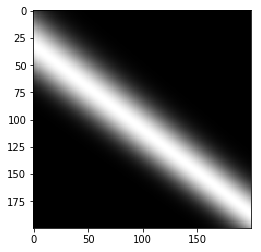

In [31]:
plt.imshow(pixel_probabilities)
plt.gray()
plt.show()

In [ ]:
road_prob_dist = NormalProbabilityDist(two_stddev=0.4)

camera_height_
resolution = (100, 100)
yaw_range = 60 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # doesn't really matter

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitch_range = np.array([31.0, 85.0])

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaw_range = np.array([center_yaw_deg - yaw_range, center_yaw_deg + yaw_range])

fov_h_range = np.array([20.0, 120.0])
fov_v_range = fov_h_range.copy()
